# 🔒 **Brute Force Detection - Modelado con CSE-CIC-IDS2018**

## Dataset Consolidado y Balanceado

### Características del Dataset:
- **Total de registros**: 763,568
- **Balance**: 50% Brute Force / 50% Benign (381,784 cada uno)
- **Features**: 60 (después de eliminar correlaciones >0.99)
- **Tipos de Brute Force**: FTP, SSH, Web, XSS (consolidados)
- **Tamaño**: 449 MB
- **Preprocessing**: Normalizado [0-1], sin nulos, sin valores infinitos

### Pipeline de Modelado:
1. Configuración e Imports
2. Carga del Dataset Preprocesado
3. Split Train/Test (80/20 estratificado)
4. Entrenamiento de 4 Modelos (Logistic Regression, Linear SVM, Random Forest, Gradient Boosting)
5. Comparación de Modelos
6. Análisis del Mejor Modelo
7. Feature Importance
8. Guardar Resultados

### Métricas Esperadas:
- **F1-Score**: 0.95-0.99 (dataset balanceado con features muy discriminantes)
- **Precision**: 0.95-0.99
- **Recall**: 0.94-0.99

---

## 📦 **FASE 0: Configuración e Imports**

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import warnings

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            f1_score, precision_score, recall_score,
                            accuracy_score, roc_auc_score, roc_curve)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías importadas correctamente")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Scikit-learn version: {sklearn.__version__}")

✓ Librerías importadas correctamente
✓ Pandas version: 2.1.4
✓ Scikit-learn version: 1.8.0


## 📂 **FASE 1: Configuración de Rutas y Parámetros**

In [2]:
# Rutas
DATA_PATH = '../../processed_data/brute_force_balanced.csv'
OUTPUT_DIR = '../outputs'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')

# Crear directorios si no existen
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Parámetros
RANDOM_STATE = 42
TEST_SIZE = 0.20
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

print(f"✓ Directorio de modelos: {MODELS_DIR}")
print(f"✓ Directorio de resultados: {RESULTS_DIR}")
print(f"✓ Random state: {RANDOM_STATE}")
print(f"✓ Test size: {TEST_SIZE * 100}%")

✓ Directorio de modelos: ../outputs/models
✓ Directorio de resultados: ../outputs/results
✓ Random state: 42
✓ Test size: 20.0%


## 📊 **FASE 2: Carga del Dataset Preprocesado**

In [3]:
print("="*70)
print("CARGANDO DATASET PREPROCESADO")
print("="*70)

# Cargar dataset
df = pd.read_csv(DATA_PATH)

print(f"\nDataset cargado:")
print(f"  Registros: {len(df):,}")
print(f"  Features: {df.shape[1] - 1} (sin contar Label)")
print(f"  Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar balance
print(f"\nDistribución de clases:")
print(df['Label'].value_counts())

balance_ratio = df['Label'].value_counts().min() / df['Label'].value_counts().max()
print(f"\nBalance: {balance_ratio * 100:.1f}%")

# Verificar calidad
print(f"\nCalidad del dataset:")
print(f"  Valores nulos: {df.isnull().sum().sum()}")
print(f"  Duplicados: {df.duplicated().sum():,} ({df.duplicated().sum() / len(df) * 100:.1f}%)")

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
df.head()

CARGANDO DATASET PREPROCESADO

Dataset cargado:
  Registros: 763,568
  Features: 60 (sin contar Label)
  Memoria: 391.41 MB

Distribución de clases:
Label
Benign         381784
Brute Force    381784
Name: count, dtype: int64

Balance: 100.0%

Calidad del dataset:
  Valores nulos: 0
  Duplicados: 224,439 (29.4%)

Primeras 5 filas:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Fwd IAT Std,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,Down/Up Ratio,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Label
0,0.7967,0.3529,0.9500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0385,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0192,0.0385,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0119,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2372,0.9695,0.0000,0.4167,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Benign
1,0.0008,1.0000,0.9989,0.0000,0.0000,0.0000,0.0000,0.0007,0.0295,0.0038,0.0000,0.0177,0.0486,0.0385,0.0000,0.0001,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0004,0.0295,0.0011,0.0208,0.0018,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0119,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Benign
2,0.0068,0.3529,0.8553,0.0020,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,0.0015,0.0019,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1250,0.1250,0.0000,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Benign
3,0.0008,1.0000,0.9983,0.0004,0.0000,0.0000,0.0000,0.0006,0.0274,0.0036,0.0000,0.0247,0.0678,0.0537,0.0000,0.0000,0.0000,0.0001,0.0002,0.0002,0.0000,0.0002,0.0002,0.0000,0.0002,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0274,0.0015,0.0252,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0119,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Benign
4,0.0003,0.3529,0.0432,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0119,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4102,0.0000,0.0000,0.8333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Brute Force


In [4]:
# Información del dataset
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763568 entries, 0 to 763567
Data columns (total 61 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           763568 non-null  float64
 1   Protocol           763568 non-null  float64
 2   Timestamp          763568 non-null  float64
 3   Flow Duration      763568 non-null  float64
 4   Tot Fwd Pkts       763568 non-null  float64
 5   Tot Bwd Pkts       763568 non-null  float64
 6   TotLen Fwd Pkts    763568 non-null  float64
 7   Fwd Pkt Len Max    763568 non-null  float64
 8   Fwd Pkt Len Min    763568 non-null  float64
 9   Fwd Pkt Len Mean   763568 non-null  float64
 10  Fwd Pkt Len Std    763568 non-null  float64
 11  Bwd Pkt Len Max    763568 non-null  float64
 12  Bwd Pkt Len Min    763568 non-null  float64
 13  Bwd Pkt Len Mean   763568 non-null  float64
 14  Bwd Pkt Len Std    763568 non-null  float64
 15  Flow Byts/s        763568

## 🔀 **FASE 3: Split Train/Test (80/20 Estratificado)**

**Estrategia**:
- Split estratificado 80/20 (mantiene balance 50/50 en train y test)
- Random state fijo para reproducibilidad
- NO usamos temporal split porque el dataset ya está shuffled
- NO usamos SMOTE porque el dataset ya está balanceado

In [5]:
print("="*70)
print("SPLIT TRAIN/TEST")
print("="*70)

# Separar features y target
X = df.drop('Label', axis=1)
y = df['Label']

# Mapear labels a numérico
label_mapping = {'Benign': 0, 'Brute Force': 1}
y_numeric = y.map(label_mapping)

print(f"\nFeatures (X):")
print(f"  Shape: {X.shape}")
print(f"  Columnas: {list(X.columns[:5])} ... (total: {len(X.columns)})")

print(f"\nTarget (y):")
print(f"  Shape: {y.shape}")
print(f"  Clases: {y.unique()}")
print(f"  Mapeo: {label_mapping}")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_numeric
)

print(f"\nDatos de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Distribución: {dict(y_train.value_counts())}")

print(f"\nDatos de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Distribución: {dict(y_test.value_counts())}")

# Verificar balance en ambos sets
train_balance = y_train.value_counts().min() / y_train.value_counts().max()
test_balance = y_test.value_counts().min() / y_test.value_counts().max()

print(f"\nBalance en train: {train_balance * 100:.1f}%")
print(f"Balance en test: {test_balance * 100:.1f}%")
print("✓ Split estratificado mantiene el balance")

SPLIT TRAIN/TEST

Features (X):
  Shape: (763568, 60)
  Columnas: ['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts'] ... (total: 60)

Target (y):
  Shape: (763568,)
  Clases: ['Benign' 'Brute Force']
  Mapeo: {'Benign': 0, 'Brute Force': 1}

Datos de entrenamiento:
  X_train: (610854, 60)
  y_train: (610854,)
  Distribución: {1: 305427, 0: 305427}

Datos de prueba:
  X_test: (152714, 60)
  y_test: (152714,)
  Distribución: {1: 76357, 0: 76357}

Balance en train: 100.0%
Balance en test: 100.0%
✓ Split estratificado mantiene el balance


## 🚀 **FASE 4: Entrenamiento de Modelos**

Entrenaremos 4 modelos:
1. **Logistic Regression** (baseline - modelo lineal simple)
2. **Linear SVM** (Support Vector Machine lineal - rápido y escalable)
3. **Random Forest** (ensemble de árboles de decisión)
4. **Gradient Boosting** (boosting secuencial de árboles)

**Nota**: Usamos LinearSVC en lugar de SVC con kernel RBF porque es mucho más eficiente en datasets grandes (>100K registros). LinearSVC tiene complejidad O(n) vs O(n²-n³) del kernel RBF.

In [6]:
print("="*70)
print("ENTRENAMIENTO DE MODELOS")
print("="*70)

# Configuración de modelos
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        solver='lbfgs',
        n_jobs=-1
    ),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(
            random_state=RANDOM_STATE,
            max_iter=2000,
            dual='auto'
        ),
        cv=3  # 3-fold CV para calibración de probabilidades
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=10,
        learning_rate=0.1,
        min_samples_split=10,
        min_samples_leaf=5
    )
}

print(f"\nModelos configurados: {len(models)}")
for name in models.keys():
    print(f"  - {name}")

ENTRENAMIENTO DE MODELOS

Modelos configurados: 4
  - Logistic Regression
  - Linear SVM
  - Random Forest
  - Gradient Boosting


In [7]:
# Entrenar modelos
import time

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"ENTRENANDO: {name}")
    print(f"{'='*70}")

    # Entrenar
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Probabilidades (para ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_prob_test = model.predict_proba(X_test)[:, 1]
    else:
        y_prob_test = model.decision_function(X_test)

    # Métricas Train
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)

    # Métricas Test
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_prob_test)

    # Guardar resultados
    results[name] = {
        'model': name,
        'training_time': training_time,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_pred_test': y_pred_test,
        'y_prob_test': y_prob_test
    }

    trained_models[name] = model

    # Mostrar resultados
    print(f"\nTiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"\nMétricas en TRAIN:")
    print(f"  Accuracy:  {train_accuracy:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall:    {train_recall:.4f}")
    print(f"  F1-Score:  {train_f1:.4f}")

    print(f"\nMétricas en TEST:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    print(f"  ROC-AUC:   {test_roc_auc:.4f}")

    # Overfitting check
    overfitting = train_f1 - test_f1
    if overfitting > 0.05:
        print(f"\n⚠️ Posible overfitting detectado (diff F1: {overfitting:.4f})")
    else:
        print(f"\n✓ Sin overfitting significativo (diff F1: {overfitting:.4f})")

print(f"\n{'='*70}")
print("✓ TODOS LOS MODELOS ENTRENADOS")
print(f"{'='*70}")


ENTRENANDO: Logistic Regression

Tiempo de entrenamiento: 6.93 segundos

Métricas en TRAIN:
  Accuracy:  0.9985
  Precision: 0.9985
  Recall:    0.9984
  F1-Score:  0.9985

Métricas en TEST:
  Accuracy:  0.9983
  Precision: 0.9982
  Recall:    0.9985
  F1-Score:  0.9984
  ROC-AUC:   0.9997

✓ Sin overfitting significativo (diff F1: 0.0001)

ENTRENANDO: Linear SVM

Tiempo de entrenamiento: 55.01 segundos

Métricas en TRAIN:
  Accuracy:  0.9989
  Precision: 0.9992
  Recall:    0.9986
  F1-Score:  0.9989

Métricas en TEST:
  Accuracy:  0.9988
  Precision: 0.9989
  Recall:    0.9987
  F1-Score:  0.9988
  ROC-AUC:   0.9999

✓ Sin overfitting significativo (diff F1: 0.0001)

ENTRENANDO: Random Forest

Tiempo de entrenamiento: 29.08 segundos

Métricas en TRAIN:
  Accuracy:  0.9997
  Precision: 1.0000
  Recall:    0.9995
  F1-Score:  0.9997

Métricas en TEST:
  Accuracy:  0.9997
  Precision: 1.0000
  Recall:    0.9994
  F1-Score:  0.9997
  ROC-AUC:   1.0000

✓ Sin overfitting significativo (d

## 📊 **FASE 5: Comparación de Modelos**

In [8]:
# Crear DataFrame de comparación
comparison_df = pd.DataFrame(results).T

# Seleccionar columnas relevantes
comparison_metrics = comparison_df[[
    'training_time',
    'test_accuracy', 'test_precision', 'test_recall',
    'test_f1', 'test_roc_auc'
]].copy()

# Renombrar columnas
comparison_metrics.columns = ['Tiempo (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Ordenar por F1-Score
comparison_metrics = comparison_metrics.sort_values('F1-Score', ascending=False)

print("="*70)
print("COMPARACIÓN DE MODELOS")
print("="*70)
print("\nMétricas en TEST (ordenados por F1-Score):")
print(comparison_metrics)

# Identificar mejor modelo
best_model_name = comparison_metrics['F1-Score'].idxmax()
best_f1 = comparison_metrics.loc[best_model_name, 'F1-Score']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

COMPARACIÓN DE MODELOS

Métricas en TEST (ordenados por F1-Score):
                    Tiempo (s) Accuracy Precision Recall F1-Score ROC-AUC
Gradient Boosting    1430.8936   0.9999    0.9999 0.9999   0.9999  1.0000
Random Forest          29.0815   0.9997    1.0000 0.9994   0.9997  1.0000
Linear SVM             55.0091   0.9988    0.9989 0.9987   0.9988  0.9999
Logistic Regression     6.9292   0.9983    0.9982 0.9985   0.9984  0.9997

🏆 MEJOR MODELO: Gradient Boosting
   F1-Score: 0.9999


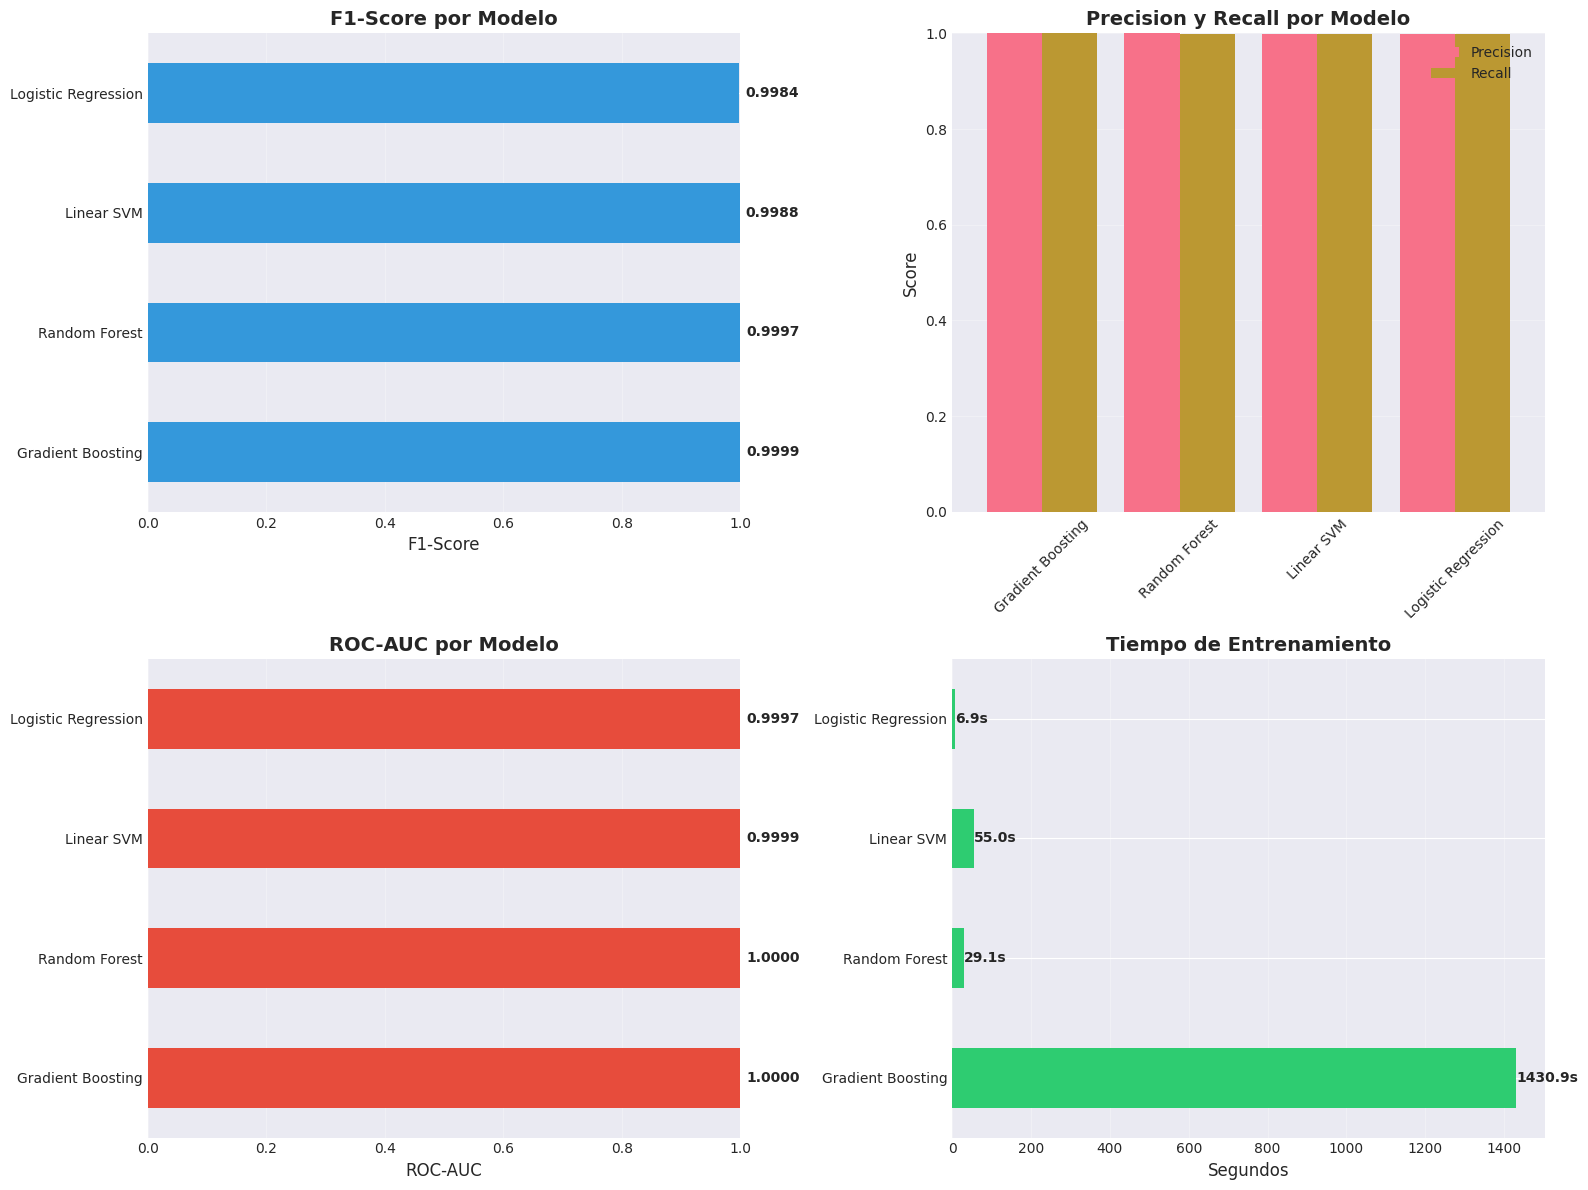


✓ Gráficos de comparación generados


In [9]:
# Visualización de comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1-Score
ax1 = axes[0, 0]
comparison_metrics['F1-Score'].plot(kind='barh', ax=ax1, color='#3498db')
ax1.set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1-Score', fontsize=12)
ax1.set_xlim(0, 1)
ax1.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_metrics['F1-Score']):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# 2. Precision y Recall
ax2 = axes[0, 1]
comparison_metrics[['Precision', 'Recall']].plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Precision y Recall por Modelo', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# 3. ROC-AUC
ax3 = axes[1, 0]
comparison_metrics['ROC-AUC'].plot(kind='barh', ax=ax3, color='#e74c3c')
ax3.set_title('ROC-AUC por Modelo', fontsize=14, fontweight='bold')
ax3.set_xlabel('ROC-AUC', fontsize=12)
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_metrics['ROC-AUC']):
    ax3.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# 4. Tiempo de entrenamiento
ax4 = axes[1, 1]
comparison_metrics['Tiempo (s)'].plot(kind='barh', ax=ax4, color='#2ecc71')
ax4.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
ax4.set_xlabel('Segundos', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_metrics['Tiempo (s)']):
    ax4.text(v + 1, i, f'{v:.1f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Gráficos de comparación generados")

## 🏆 **FASE 6: Análisis del Mejor Modelo**

ANÁLISIS DETALLADO: Gradient Boosting

Matriz de Confusión:
[[76353     4]
 [    5 76352]]


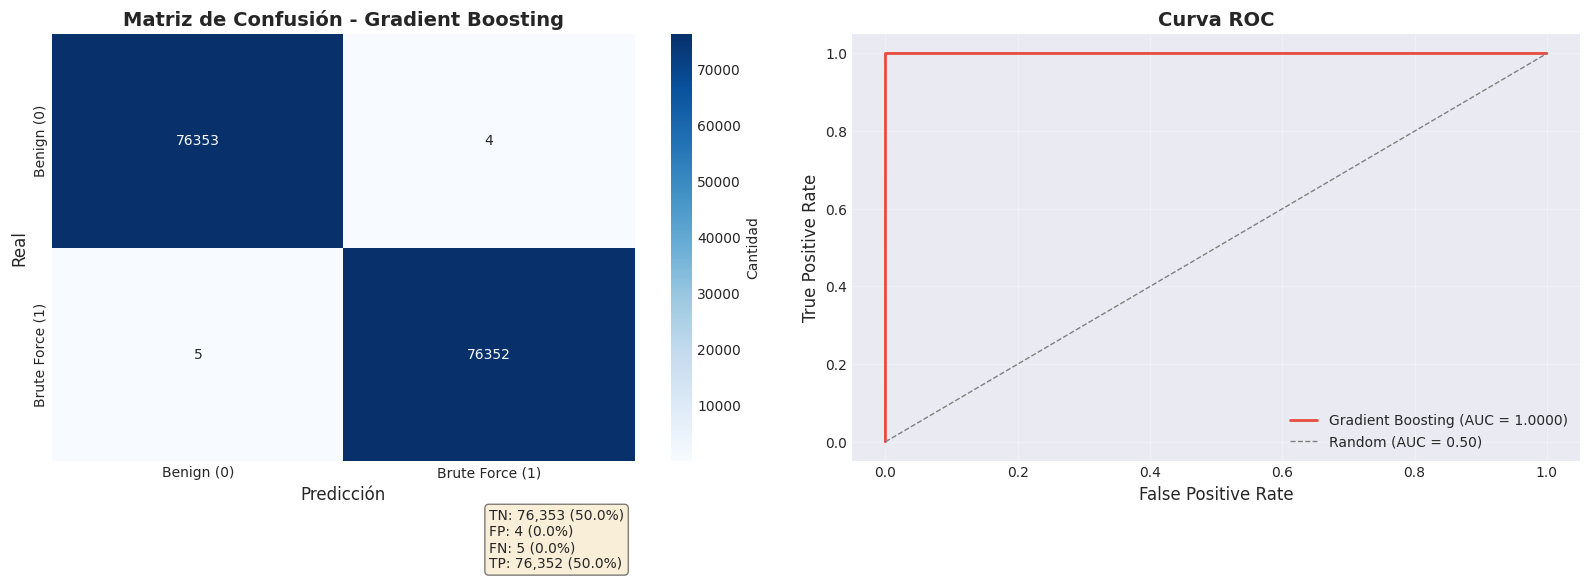


✓ Visualizaciones generadas


In [10]:
print("="*70)
print(f"ANÁLISIS DETALLADO: {best_model_name}")
print("="*70)

# Obtener resultados del mejor modelo
best_results = results[best_model_name]
best_model = trained_models[best_model_name]

# Matriz de confusión
cm = confusion_matrix(y_test, best_results['y_pred_test'])

print(f"\nMatriz de Confusión:")
print(cm)

# Visualizar matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            cbar_kws={'label': 'Cantidad'})
ax1.set_title(f'Matriz de Confusión - {best_model_name}',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicción', fontsize=12)
ax1.set_ylabel('Real', fontsize=12)
ax1.set_xticklabels(['Benign (0)', 'Brute Force (1)'])
ax1.set_yticklabels(['Benign (0)', 'Brute Force (1)'])

# Agregar estadísticas
TN, FP, FN, TP = cm.ravel()
total = TN + FP + FN + TP

text = f'TN: {TN:,} ({TN/total*100:.1f}%)\n'
text += f'FP: {FP:,} ({FP/total*100:.1f}%)\n'
text += f'FN: {FN:,} ({FN/total*100:.1f}%)\n'
text += f'TP: {TP:,} ({TP/total*100:.1f}%)'

ax1.text(1.5, 2.5, text, fontsize=10, bbox=dict(boxstyle='round',
         facecolor='wheat', alpha=0.5))

# Curva ROC
ax2 = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, best_results['y_prob_test'])
roc_auc = best_results['test_roc_auc']

ax2.plot(fpr, tpr, color='#e74c3c', linewidth=2,
         label=f'{best_model_name} (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1,
         label='Random (AUC = 0.50)')
ax2.set_title('Curva ROC', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas")

In [11]:
# Classification Report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}")

target_names = ['Benign (0)', 'Brute Force (1)']
report = classification_report(y_test, best_results['y_pred_test'],
                              target_names=target_names, digits=4)
print(report)

# Análisis de errores
print(f"\n{'='*70}")
print("ANÁLISIS DE ERRORES")
print(f"{'='*70}")

TN, FP, FN, TP = cm.ravel()
total = TN + FP + FN + TP

print(f"\nTrue Negatives (TN):  {TN:,} ({TN/total*100:.2f}%) - Benign correctamente clasificado")
print(f"False Positives (FP): {FP:,} ({FP/total*100:.2f}%) - Benign clasificado como Brute Force ⚠️")
print(f"False Negatives (FN): {FN:,} ({FN/total*100:.2f}%) - Brute Force clasificado como Benign 🚨")
print(f"True Positives (TP):  {TP:,} ({TP/total*100:.2f}%) - Brute Force correctamente clasificado")

print(f"\nTotal de errores: {FP + FN:,} ({(FP + FN)/total*100:.2f}%)")
print(f"Total correcto: {TN + TP:,} ({(TN + TP)/total*100:.2f}%)")

# Tasas de error
fpr_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr_rate = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f"\nFalse Positive Rate: {fpr_rate:.4f} ({fpr_rate*100:.2f}%)")
print(f"False Negative Rate: {fnr_rate:.4f} ({fnr_rate*100:.2f}%)")

if FN > FP:
    print("\n⚠️ Más False Negatives que False Positives")
    print("   → El modelo tiende a NO detectar algunos ataques (más conservador)")
elif FP > FN:
    print("\n⚠️ Más False Positives que False Negatives")
    print("   → El modelo tiende a generar falsas alarmas (más agresivo)")
else:
    print("\n✓ Balance equilibrado entre FP y FN")


CLASSIFICATION REPORT
                 precision    recall  f1-score   support

     Benign (0)     0.9999    0.9999    0.9999     76357
Brute Force (1)     0.9999    0.9999    0.9999     76357

       accuracy                         0.9999    152714
      macro avg     0.9999    0.9999    0.9999    152714
   weighted avg     0.9999    0.9999    0.9999    152714


ANÁLISIS DE ERRORES

True Negatives (TN):  76,353 (50.00%) - Benign correctamente clasificado
False Positives (FP): 4 (0.00%) - Benign clasificado como Brute Force ⚠️
False Negatives (FN): 5 (0.00%) - Brute Force clasificado como Benign 🚨
True Positives (TP):  76,352 (50.00%) - Brute Force correctamente clasificado

Total de errores: 9 (0.01%)
Total correcto: 152,705 (99.99%)

False Positive Rate: 0.0001 (0.01%)
False Negative Rate: 0.0001 (0.01%)

⚠️ Más False Negatives que False Positives
   → El modelo tiende a NO detectar algunos ataques (más conservador)


## 🔍 **FASE 7: Feature Importance (Importancia de Features)**

Identificar cuáles son las features más importantes para la detección de Brute Force.

FEATURE IMPORTANCE

Top 20 Features más importantes:
              Feature  Importance
53   Fwd Seg Size Min      0.9886
0            Dst Port      0.0061
50  Init Fwd Win Byts      0.0016
6     TotLen Fwd Pkts      0.0012
2           Timestamp      0.0006
16        Flow Pkts/s      0.0005
33        Pkt Len Max      0.0004
17      Flow IAT Mean      0.0003
38       RST Flag Cnt      0.0002
32        Pkt Len Min      0.0002
3       Flow Duration      0.0000
19       Flow IAT Max      0.0000
20        Fwd IAT Std      0.0000
10    Fwd Pkt Len Std      0.0000
31         Bwd Pkts/s      0.0000
7     Fwd Pkt Len Max      0.0000
9    Fwd Pkt Len Mean      0.0000
11    Bwd Pkt Len Max      0.0000
36        Pkt Len Var      0.0000
13   Bwd Pkt Len Mean      0.0000


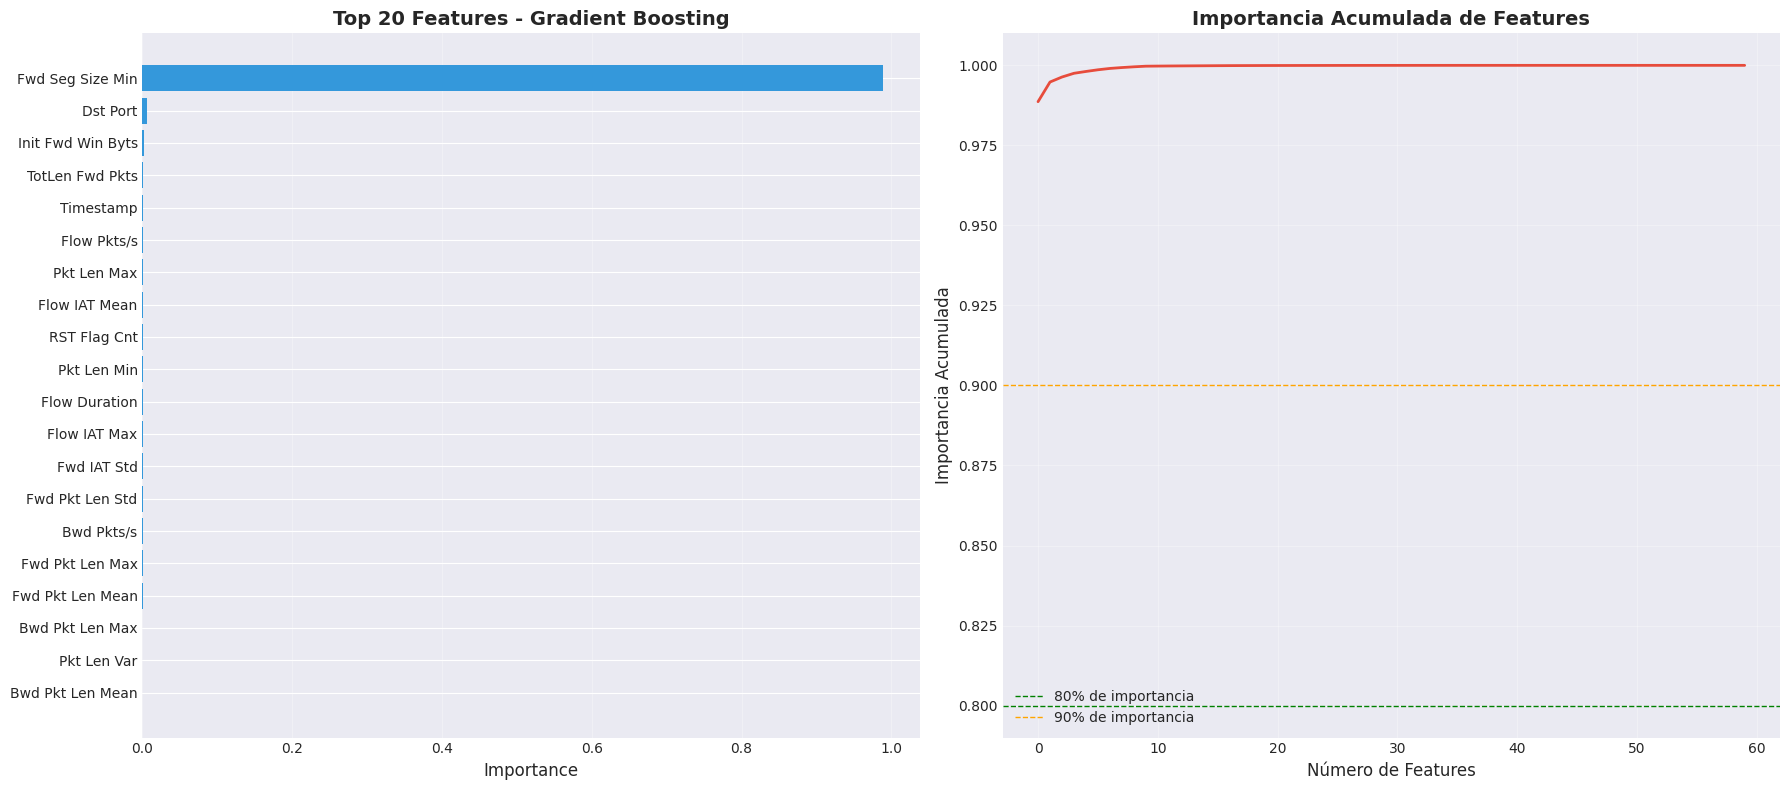


📊 Análisis de Features:
  Features para 80% importancia: 54 de 60
  Features para 90% importancia: 54 de 60

🎯 Comparación con hallazgos del EDA:

  Features importantes según EDA:
    - Bwd Pkts/s                    : 0.0000 (Rank #32)
    - Flow Pkts/s                   : 0.0005 (Rank #17)
    - URG Flag Cnt                  : 0.0000 (Rank #42)
    - PSH Flag Cnt                  : 0.0000 (Rank #40)
    - Flow Duration                 : 0.0000 (Rank #4)
    - Init Bwd Win Byts             : 0.0000 (Rank #52)
    - Timestamp                     : 0.0006 (Rank #3)

✓ Análisis de Feature Importance completado


In [12]:
print("="*70)
print("FEATURE IMPORTANCE")
print("="*70)

# Verificar si el modelo tiene feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Random Forest o Gradient Boosting
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    # Crear DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(f"\nTop 20 Features más importantes:")
    print(feature_importance_df.head(20))

    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Top 20 features
    ax1 = axes[0]
    top_20 = feature_importance_df.head(20)
    ax1.barh(range(len(top_20)), top_20['Importance'], color='#3498db')
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['Feature'])
    ax1.invert_yaxis()
    ax1.set_title(f'Top 20 Features - {best_model_name}',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Importance', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='x')

    # Importancia acumulada
    ax2 = axes[1]
    cumulative_importance = feature_importance_df['Importance'].cumsum()
    ax2.plot(range(len(cumulative_importance)), cumulative_importance,
             linewidth=2, color='#e74c3c')
    ax2.axhline(y=0.8, color='green', linestyle='--', linewidth=1,
                label='80% de importancia')
    ax2.axhline(y=0.9, color='orange', linestyle='--', linewidth=1,
                label='90% de importancia')
    ax2.set_title('Importancia Acumulada de Features',
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Número de Features', fontsize=12)
    ax2.set_ylabel('Importancia Acumulada', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ¿Cuántas features se necesitan para 80% y 90%?
    n_features_80 = (cumulative_importance >= 0.8).idxmax() + 1
    n_features_90 = (cumulative_importance >= 0.9).idxmax() + 1

    print(f"\n📊 Análisis de Features:")
    print(f"  Features para 80% importancia: {n_features_80} de {len(feature_names)}")
    print(f"  Features para 90% importancia: {n_features_90} de {len(feature_names)}")

    # Comparar con hallazgos del EDA
    print(f"\n🎯 Comparación con hallazgos del EDA:")
    eda_top_features = ['Bwd Pkts/s', 'Flow Pkts/s', 'URG Flag Cnt', 'PSH Flag Cnt',
                       'Flow Duration', 'Init Bwd Win Byts', 'Timestamp']

    print(f"\n  Features importantes según EDA:")
    for feat in eda_top_features:
        if feat in feature_importance_df['Feature'].values:
            importance = feature_importance_df[feature_importance_df['Feature'] == feat]['Importance'].values[0]
            rank = feature_importance_df[feature_importance_df['Feature'] == feat].index[0] + 1
            print(f"    - {feat:30s}: {importance:.4f} (Rank #{rank})")
        else:
            print(f"    - {feat:30s}: No encontrada en features")

elif hasattr(best_model, 'coef_'):
    # Logistic Regression o SVM lineal
    coefficients = np.abs(best_model.coef_[0])
    feature_names = X_train.columns

    # Crear DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', ascending=False)

    print(f"\nTop 20 Features (por coeficientes absolutos):")
    print(feature_importance_df.head(20))

    # Visualizar
    plt.figure(figsize=(14, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Coefficient'], color='#3498db')
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Features - {best_model_name}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Coefficient (Absolute)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"\n⚠️ El modelo {best_model_name} no soporta feature importance directa")
    print("   (Por ejemplo, SVM con kernel RBF no tiene coeficientes lineales)")

print("\n✓ Análisis de Feature Importance completado")

## 💾 **FASE 8: Guardar Resultados**

Guardamos:
1. Todos los modelos entrenados
2. Mejor modelo por separado
3. Métricas de comparación
4. Feature importance (si aplica)
5. Metadata del experimento

In [13]:
print("="*70)
print("GUARDANDO RESULTADOS")
print("="*70)

# 1. Guardar todos los modelos
print("\n1. Guardando todos los modelos...")
for name, model in trained_models.items():
    model_filename = f"{name.replace(' ', '_').lower()}_{TIMESTAMP}.pkl"
    model_path = os.path.join(MODELS_DIR, model_filename)
    joblib.dump(model, model_path)
    print(f"  ✓ {name}: {model_filename}")

# 2. Guardar mejor modelo con nombre especial
print("\n2. Guardando mejor modelo...")
best_model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}_{TIMESTAMP}.pkl"
best_model_path = os.path.join(MODELS_DIR, best_model_filename)
joblib.dump(best_model, best_model_path)
print(f"  ✓ Mejor modelo: {best_model_filename}")

# 3. Guardar métricas de comparación
print("\n3. Guardando métricas de comparación...")
comparison_filename = f"model_comparison_{TIMESTAMP}.csv"
comparison_path = os.path.join(RESULTS_DIR, comparison_filename)
comparison_metrics.to_csv(comparison_path)
print(f"  ✓ Comparación: {comparison_filename}")

# 4. Guardar feature importance (si existe)
print("\n4. Guardando feature importance...")
if 'feature_importance_df' in locals():
    fi_filename = f"feature_importance_{TIMESTAMP}.csv"
    fi_path = os.path.join(RESULTS_DIR, fi_filename)
    feature_importance_df.to_csv(fi_path, index=False)
    print(f"  ✓ Feature importance: {fi_filename}")
else:
    print(f"  ⚠️ Feature importance no disponible para {best_model_name}")

# 5. Guardar metadata del experimento
print("\n5. Guardando metadata del experimento...")
metadata = {
    'timestamp': TIMESTAMP,
    'dataset': {
        'path': DATA_PATH,
        'total_records': len(df),
        'n_features': X.shape[1],
        'balance': {
            'Benign': int(df[df['Label'] == 'Benign'].shape[0]),
            'Brute Force': int(df[df['Label'] == 'Brute Force'].shape[0])
        }
    },
    'split': {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'train_size': len(X_train),
        'test_size': len(X_test)
    },
    'models_trained': list(models.keys()),
    'best_model': {
        'name': best_model_name,
        'filename': best_model_filename,
        'metrics': {
            'accuracy': float(best_results['test_accuracy']),
            'precision': float(best_results['test_precision']),
            'recall': float(best_results['test_recall']),
            'f1_score': float(best_results['test_f1']),
            'roc_auc': float(best_results['test_roc_auc'])
        },
        'confusion_matrix': {
            'TN': int(TN),
            'FP': int(FP),
            'FN': int(FN),
            'TP': int(TP)
        }
    }
}

metadata_filename = f"experiment_metadata_{TIMESTAMP}.json"
metadata_path = os.path.join(RESULTS_DIR, metadata_filename)
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ Metadata: {metadata_filename}")

print(f"\n{'='*70}")
print("✓ TODOS LOS RESULTADOS GUARDADOS")
print(f"{'='*70}")
print(f"\nUbicación de archivos:")
print(f"  Modelos: {MODELS_DIR}")
print(f"  Resultados: {RESULTS_DIR}")

GUARDANDO RESULTADOS

1. Guardando todos los modelos...
  ✓ Logistic Regression: logistic_regression_20260117_021309.pkl
  ✓ Linear SVM: linear_svm_20260117_021309.pkl
  ✓ Random Forest: random_forest_20260117_021309.pkl
  ✓ Gradient Boosting: gradient_boosting_20260117_021309.pkl

2. Guardando mejor modelo...
  ✓ Mejor modelo: best_model_gradient_boosting_20260117_021309.pkl

3. Guardando métricas de comparación...
  ✓ Comparación: model_comparison_20260117_021309.csv

4. Guardando feature importance...
  ✓ Feature importance: feature_importance_20260117_021309.csv

5. Guardando metadata del experimento...
  ✓ Metadata: experiment_metadata_20260117_021309.json

✓ TODOS LOS RESULTADOS GUARDADOS

Ubicación de archivos:
  Modelos: ../outputs/models
  Resultados: ../outputs/results


## ✅ **RESUMEN FINAL**

In [14]:
print("="*70)
print("RESUMEN FINAL DEL MODELADO")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total de registros: {len(df):,}")
print(f"  Features: {X.shape[1]}")
print(f"  Balance: 50% Benign / 50% Brute Force")

print(f"\n🔀 Split:")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Test: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n🤖 Modelos Entrenados: {len(models)}")
for name in models.keys():
    f1 = results[name]['test_f1']
    print(f"  - {name:25s}: F1-Score = {f1:.4f}")

print(f"\n🏆 Mejor Modelo: {best_model_name}")
print(f"  Accuracy:  {best_results['test_accuracy']:.4f}")
print(f"  Precision: {best_results['test_precision']:.4f}")
print(f"  Recall:    {best_results['test_recall']:.4f}")
print(f"  F1-Score:  {best_results['test_f1']:.4f}")
print(f"  ROC-AUC:   {best_results['test_roc_auc']:.4f}")

print(f"\n📁 Archivos Generados:")
print(f"  Modelos: {len(trained_models)} archivos .pkl")
print(f"  Mejor modelo: {best_model_filename}")
print(f"  Comparación: {comparison_filename}")
if 'feature_importance_df' in locals():
    print(f"  Feature importance: {fi_filename}")
print(f"  Metadata: {metadata_filename}")

print(f"\n🎯 Próximos Pasos:")
print("  1. Revisar feature importance y comparar con hallazgos del EDA")
print("  2. Analizar errores (FP y FN) para identificar patrones")
print("  3. Considerar ensemble de modelos si se necesita mejor performance")
print("  4. Crear API REST para servir el mejor modelo")
print("  5. Integrar con frontend")

print(f"\n{'='*70}")
print("✓ MODELADO COMPLETADO EXITOSAMENTE")
print(f"{'='*70}")

RESUMEN FINAL DEL MODELADO

📊 Dataset:
  Total de registros: 763,568
  Features: 60
  Balance: 50% Benign / 50% Brute Force

🔀 Split:
  Train: 610,854 (80.0%)
  Test: 152,714 (20.0%)

🤖 Modelos Entrenados: 4
  - Logistic Regression      : F1-Score = 0.9984
  - Linear SVM               : F1-Score = 0.9988
  - Random Forest            : F1-Score = 0.9997
  - Gradient Boosting        : F1-Score = 0.9999

🏆 Mejor Modelo: Gradient Boosting
  Accuracy:  0.9999
  Precision: 0.9999
  Recall:    0.9999
  F1-Score:  0.9999
  ROC-AUC:   1.0000

📁 Archivos Generados:
  Modelos: 4 archivos .pkl
  Mejor modelo: best_model_gradient_boosting_20260117_021309.pkl
  Comparación: model_comparison_20260117_021309.csv
  Feature importance: feature_importance_20260117_021309.csv
  Metadata: experiment_metadata_20260117_021309.json

🎯 Próximos Pasos:
  1. Revisar feature importance y comparar con hallazgos del EDA
  2. Analizar errores (FP y FN) para identificar patrones
  3. Considerar ensemble de modelos si